In [1]:
import math
import json
import numpy as np
import matplotlib.pyplot as plt

import openrtdynamics2.lang as dy
import openrtdynamics2.py_execute as dyexe
from openrtdynamics2.ORTDtoNumpy import ORTDtoNumpy

from vehicle_lib.vehicle_lib import *


In [2]:
Ts = 0.01

In [3]:
# load track data
with open("track_data/simple_track.json", "r") as read_file:
    track_data = json.load(read_file)


# Run a simulation to generate test data

Set-up a simulation of a vehicle (bicycle model). The vehicle is controlled to follow a given path. In addition, an intended lateral distance $\Delta l$ is modulated by applying a pre-defined profile to the reference $\Delta l_r$. 

# define a profile for the lateral distance

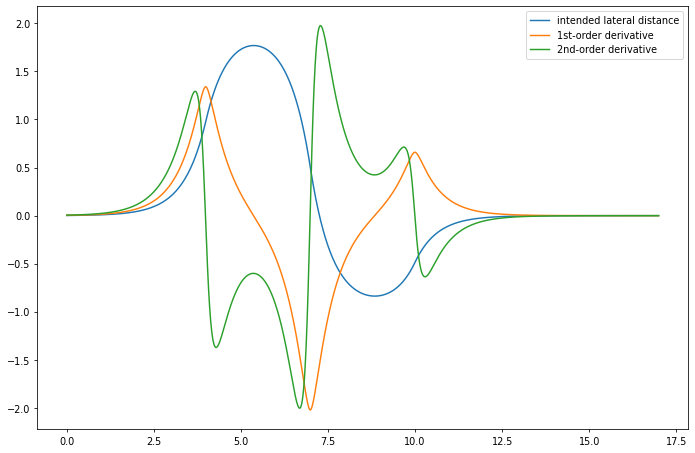

In [4]:

scale = 1

Delta_l_r_profile = filtfilt(Ts, np.concatenate((  np.zeros(400*scale), 2*np.ones(300*scale), -np.ones(300*scale),  np.zeros(700*scale) )), cutoff_frq=0.005 )

Delta_l_r_dot_profile = numerical_derivative(Ts, Delta_l_r_profile)
Delta_l_r_dotdot_profile = numerical_derivative(Ts, Delta_l_r_dot_profile)

time = make_time(Ts, Delta_l_r_profile)
plt.figure(figsize=(12,8), dpi=70)
plt.plot(time, Delta_l_r_profile)
plt.plot(time, Delta_l_r_dot_profile)
plt.plot(time, Delta_l_r_dotdot_profile)
plt.legend(['intended lateral distance', '1st-order derivative', '2nd-order derivative'])
plt.show()

##### 


Run the simulation given parameters to define the steering rates


In [44]:

def process_data( path, input_signals ):
    
    
    Ts, wheelbase, velocity, Delta_l_r, Delta_l_r_dot, Delta_l_r_dotdot = input_signals
    
    op = path_lateral_modification2(Ts, wheelbase, path, velocity, Delta_l_r, Delta_l_r_dot, Delta_l_r_dotdot)

    return op
    

def async_path_data_handler(input_sample_valid, async_input_data_valid, path_sample, process_fn, input_signals):
    
    samples_in_buffer = 10000
        
    # allocate the buffers to collect the input data
    path = create_path_horizon( samples_in_buffer )
    
    # write new data into the buffer as valid samples arrive 
    with dy.sub_if(async_input_data_valid, subsystem_name='store_input_data') as system:
        
        append_to_path_horizon(path, path_sample)

        
    #
    # Execute the data processing system in case vaild reference data is 
    # available. Otherwise the output variables are undefined and shall be 
    # discarded by the system in which this schematic is embedded into.
    #
    
    with dy.sub_if(input_sample_valid, subsystem_name='process_data', prevent_output_computation=True) as system:
        
        # perform the interpolation
        output_signals = process_fn(path, input_signals)

        #
        # compute the amount of data available ahead
        #


        system.set_outputs( output_signals.to_list() )
    output_signals.replace_signals( system.outputs )
    
    
    # is the controller executed and yielded valid outputs?
    control_variables_valid = dy.logic_and( input_sample_valid, output_signals['output_valid'] )
    
    # sample & hold of some output signals that are needed
    output_signals['d_star'] = dy.sample_and_hold(
        output_signals['d_star'], 
        control_variables_valid, 
        initial_state = 0 
    )
    
    output_signals['minimal_read_position'] = dy.sample_and_hold(
        output_signals['minimal_read_position'], 
        control_variables_valid, 
        initial_state = 0 
    )
    

    # the length of the horizonat  
    required_distance_ahead = 30.0   # TODO: dep. on velocity

    output_signals['head_index'], output_signals['distance_at_the_end_of_horizon'] = path_horizon_head_index(path)


    # distance_at_the_end_of_horizon = rb.read_from_absolute_index(reference['time'], head_index)
    output_signals['distance_ahead'] = output_signals['distance_at_the_end_of_horizon'] - output_signals['d_star']


    # compute the number of elements in the circular buffer that are free to write
    output_signals['elements_free_to_write'] = samples_in_buffer - ( output_signals['head_index'] - output_signals['minimal_read_position'] + 1 )

    
    
   # output_signals['distance_ahead']                    = distance_ahead
   # output_signals['elements_free_to_write']            = elements_free_to_write
    
    
    
    
    

    return output_signals
#    return sync_control, current_distance, distance_at_the_end_of_horizon, distance_ahead, head_index, current_read_position, elements_free_to_write, output_signals


In [45]:
dy.clear()
system = dy.enter_system()

velocity               = dy.system_input( dy.DataTypeFloat64(1), name='velocity_',         default_value=1,      value_range=[0, 25],   title="vehicle velocity")
Delta_l_r              = dy.system_input( dy.DataTypeFloat64(1), name='Delta_l_r',         default_value=0.0,    value_range=[-10, 10], title="lateral deviation to the path")
Delta_l_r_dot          = dy.system_input( dy.DataTypeFloat64(1), name='Delta_l_r_dot',     default_value=0.0,    value_range=[-10, 10], title="1st-order time derivative of lateral deviation to the path")
Delta_l_r_dotdot       = dy.system_input( dy.DataTypeFloat64(1), name='Delta_l_r_dotdot',  default_value=0.0,    value_range=[-10, 10], title="2nd-order time derivative of lateral deviation to the path")


async_input_data_valid = dy.system_input( dy.DataTypeBoolean(1), name='async_input_data_valid')
input_sample_valid     = dy.system_input( dy.DataTypeBoolean(1), name='input_sample_valid')

path_sample = {}
path_sample['d']   = dy.system_input( dy.DataTypeFloat64(1), name='d_sample')
path_sample['x']   = dy.system_input( dy.DataTypeFloat64(1), name='x_sample')
path_sample['y']   = dy.system_input( dy.DataTypeFloat64(1), name='y_sample')
path_sample['psi'] = dy.system_input( dy.DataTypeFloat64(1), name='psi_sample')
path_sample['K']   = dy.system_input( dy.DataTypeFloat64(1), name='K_sample')



# parameters
wheelbase = 3.0

# sampling time
Ts = 0.01

# create storage for the reference path:
#path = import_path_data(track_data)

input_signals = Ts, wheelbase, velocity, Delta_l_r, Delta_l_r_dot, Delta_l_r_dotdot


output_signals = async_path_data_handler(
    input_sample_valid,
    async_input_data_valid, 
    path_sample, 
    process_data, 
    input_signals
)



# output_path = path_lateral_modification2(Ts, wheelbase, path, velocity, Delta_l_r, Delta_l_r_dot, Delta_l_r_dotdot)



#
# outputs: these are available for visualization in the html set-up
#



dy.append_output(output_signals['output_valid'],                   'output_valid')
dy.append_output(output_signals['need_more_path_input_data'],      'need_more_path_input_data')
dy.append_output(output_signals['distance_at_the_end_of_horizon'], 'distance_at_the_end_of_horizon')
dy.append_output(output_signals['distance_ahead'],                 'distance_ahead')
dy.append_output(output_signals['head_index'],                     'head_index')
dy.append_output(output_signals['read_position'],                  'read_position')
dy.append_output(output_signals['elements_free_to_write'],         'elements_free_to_write')

dy.append_output(output_signals['tracked_index'],                  'tracked_index')
dy.append_output(output_signals['d_star'],                         'path_d_star')

dy.append_output(output_signals['d'], 'path_d')
dy.append_output(output_signals['x'], 'path_x')
dy.append_output(output_signals['y'], 'path_y')
dy.append_output(output_signals['psi'], 'path_psi')
dy.append_output(output_signals['K'], 'path_K')

dy.append_output(velocity*dy.float64(1.0), 'velocity')


# generate code for Web Assembly (wasm), requires emcc (emscripten) to build
code_gen_results = dy.generate_code(template=dy.TargetWasm(enable_tracing=False), folder="generated/tmp1", build=False)




compiling system store_input_data (level 1)... 
compiling system tracker_loop (level 3)... 
compiling system Subsystem1000 (level 2)... 
compiling system controller (level 2)... 
compiling system simulation_model (level 2)... 
compiling system process_data (level 1)... 
compiling system simulation (level 0)... 
Generated code will be written to generated/tmp1 .


In [46]:
compiled_system = dyexe.CompiledCode(code_gen_results)

In [47]:

def get_next_input_sample(path):

    k_input = get_next_input_sample.cnt
    
    d, x, y, psi, K = math.nan, math.nan, math.nan, math.nan, math.nan
    
    if k_input < len(path['D']):
        reached_end = False
        
        d   = path['D'][ k_input ]
        x   = path['X'][ k_input ]
        y   = path['Y'][ k_input ]
        psi = path['PSI'][ k_input ]
        K   = path['K'][ k_input ]

        get_next_input_sample.cnt += 1
        
    else:
        reached_end = True

    return reached_end, d, x, y, psi, K

get_next_input_sample.cnt = 0



def put_input_path_sample(output_data, input_data, raw_cpp_instance, track_data):

    reached_end, d, x, y, psi, K = get_next_input_sample(track_data)

    if reached_end:
        return True
        
    input_data.input_sample_valid     = False # do not trigger the controller
    input_data.async_input_data_valid = True  # put new path data

    input_data.d_sample    = d
    input_data.x_sample    = x
    input_data.y_sample    = y
    input_data.psi_sample  = psi
    input_data.K_sample    = K 
    
    
    raw_cpp_instance.step(output_data, input_data, True, False, False)

    # update (does not change output_data)
    raw_cpp_instance.step(output_data, input_data, False, True, False)
    
    return False

        
def execute_control_step(output_data, input_data, raw_cpp_instance, input_sample):

    input_data.input_sample_valid     = True  # do not trigger the controller
    input_data.async_input_data_valid = False # put new path data

    input_data.velocity_          = input_sample[0]
    input_data.Delta_l_r          = input_sample[1]
    input_data.Delta_l_r_dot      = input_sample[2]
    input_data.Delta_l_r_dotdot   = input_sample[3]
    
    #
    raw_cpp_instance.step(output_data, input_data, True, False, False)

    # update (does not change output_data)
    raw_cpp_instance.step(output_data, input_data, False, True, False)

        
        

# Create an instance of the system (this is an instance of the c++ class wrapped by cppyy)
raw_cpp_instance = compiled_system.system_class()

# create data strutures to store I/O data
input_data  = compiled_system.system_class.Inputs()
output_data = compiled_system.system_class.Outputs()

# simulate n steps
n = len(Delta_l_r_profile)-1 #4000

#n = 20

# storage for the output data
path = {}
path['D']   = math.nan * np.zeros(n)
path['X']   = math.nan * np.zeros(n)
path['Y']   = math.nan * np.zeros(n)
path['PSI'] = math.nan * np.zeros(n)
path['K']   = math.nan * np.zeros(n)

path['D_STAR']   = math.nan * np.zeros(n)


sync_control  = [] #math.nan * np.zeros(n)
#current_distance  = [] #math.nan * np.zeros(n)
distance_at_the_end_of_horizon  = [] #math.nan * np.zeros(n)
distance_ahead  = [] #math.nan * np.zeros(n)
head_index  = [] #math.nan * np.zeros(n)
read_position  = [] #math.nan * np.zeros(n)
elements_free_to_write  = [] #math.nan * np.zeros(n)

tracked_index = []


real_world_sample_index = 0

# reset the states of the system
raw_cpp_instance.step(output_data, input_data, False, False, True)

# simulate a real time environment with regular sampling
require_next_sample = True

for i in range( 0, n ):

    while True:
    
        # run controller and see if enough path data is available 
        execute_control_step(
            output_data,
            input_data,
            raw_cpp_instance,
            input_sample = ( 
                5, 
                Delta_l_r_profile[i], 
                Delta_l_r_dot_profile[i],
                Delta_l_r_dotdot_profile[i]
            )
        )
        

        if output_data.output_valid == False:
            # print('d')
            
            # another path input sample is needed
            put_input_path_sample( output_data, input_data, raw_cpp_instance, track_data )
            

            # watch out to not cause an buffer overflow by passing too much data that cannot be
            # consumed in time! (not checked here)
            if output_data.elements_free_to_write < 10:
                1
                raise BaseException('..')
            
            
            continue
            
        else:
            # print('.')
            # controller yieded new control variables
            break

            
            
        
    distance_at_the_end_of_horizon.append( output_data.distance_at_the_end_of_horizon )
    distance_ahead.append(                 output_data.distance_ahead )
    head_index.append(                     output_data.head_index  )
    read_position.append(                  output_data.read_position )
    elements_free_to_write.append(         output_data.elements_free_to_write )

    tracked_index.append(                  output_data.tracked_index )
        

    path['D'][real_world_sample_index]     = output_data.path_d
    path['X'][real_world_sample_index]     = output_data.path_x
    path['Y'][real_world_sample_index]     = output_data.path_y
    path['PSI'][real_world_sample_index]   = output_data.path_psi
    path['K'][real_world_sample_index]     = output_data.path_K
    
    path['D_STAR'][real_world_sample_index]     = output_data.path_d_star
    

    real_world_sample_index += 1
    

In [48]:
#path

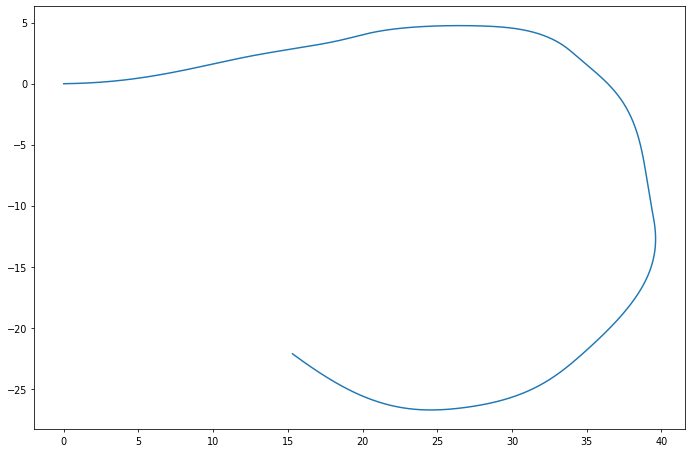

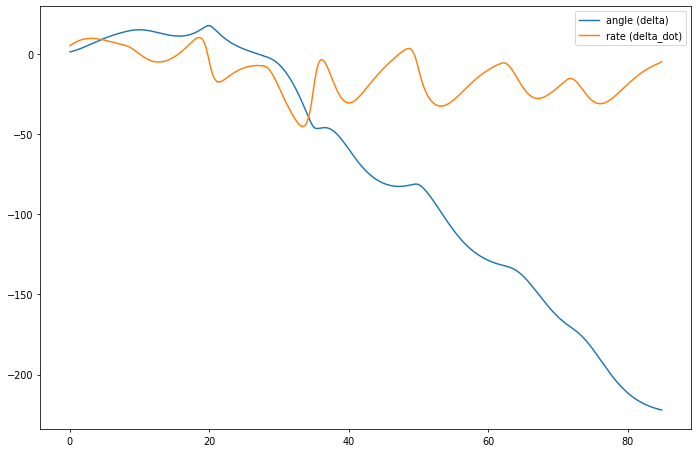

In [49]:
plot_path(path)

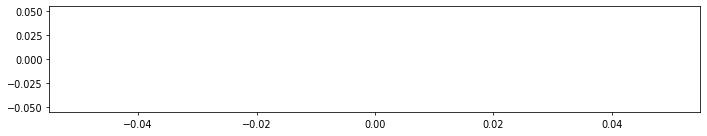

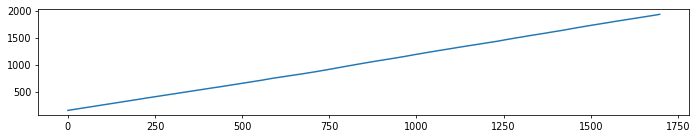

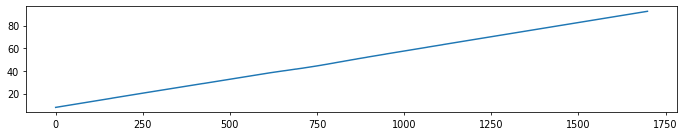

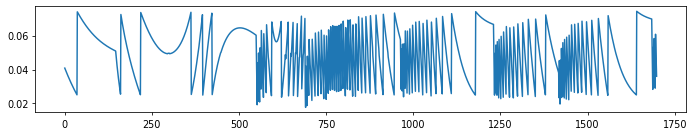

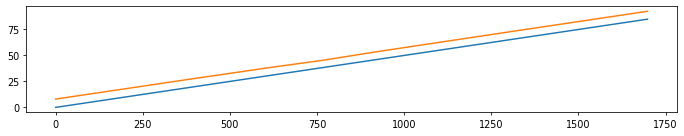

In [50]:
plt.figure(figsize=(12,2), dpi=70)
plt.plot( sync_control )
plt.show()

plt.figure(figsize=(12,2), dpi=70)
plt.plot( tracked_index )
plt.show()



plt.figure(figsize=(12,2), dpi=70)
plt.plot( distance_at_the_end_of_horizon )
plt.show()


plt.figure(figsize=(12,2), dpi=70)
plt.plot( distance_ahead )
plt.show()

plt.figure(figsize=(12,2), dpi=70)
plt.plot( path['D'] )
plt.plot( path['D_STAR'] )
plt.show()

In [51]:
#tracked_index

In [52]:
len(track_data['X'])

2725

In [53]:
len(  path['X'] )

1699

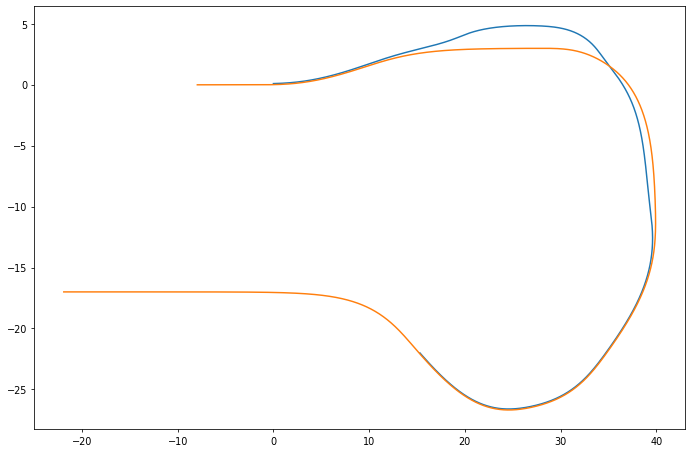

In [54]:
plt.figure(figsize=(12,8), dpi=70)
plt.plot( path['X'], path['Y']+0.1 )
plt.plot( track_data['X'], track_data['Y'] )

plt.show()